Readings:

https://omdena.com/blog/time-series-classification-model-tutorial/

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib

--2023-08-07 15:38:34--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-08-07 15:38:34--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-08-07 15:38:34--  http://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving phoenixna

In [ ]:
# Packages

import numpy as np
import pandas as pd
import tensorflow as tf
import yfinance as yf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Preprocessing data
from talib import abstract

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.12.0


<ipython-input-2-fbc437c4eb20>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Parameters

## Hyperparameters

In [ ]:
seq_len = 128

## Model parameters


In [ ]:
# Data download
symbol = "EURUSD=X"
period ='60d'
interval ='15m'

# Tensorflow model
epochs = 100

# Data handling

## Load data from YFinance

[*********************100%***********************]  1 of 1 completed


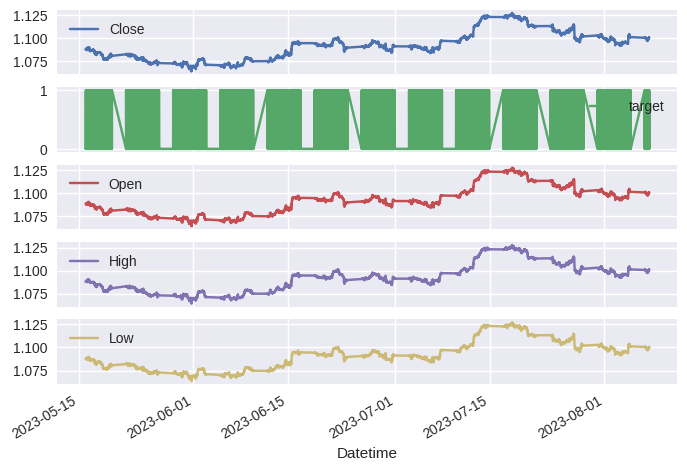

In [ ]:
# Define function for downloading finance data from yfinance

def get_yfinance_hist(symbol = "EURUSD=X", period ='1mo', interval ='15m', show_plot = True ):
    df_raw = yf.download(symbol,period= period ,interval=interval)
    df_raw["returns"] = np.log(df_raw.Close.div(df_raw.Close.shift(1)))
    df_raw.dropna(how="any",inplace=True)
    df_raw["target"] = np.where(df_raw["returns"].shift(-1) > 0, 1, 0)
    df_raw = df_raw.drop('Volume', axis=1)

    if(show_plot):
      plot_cols = ['Close', 'target', 'Open', 'High', 'Low']
      plot_features = df_raw[plot_cols]
      plot_features.index = df_raw.index
      _ = plot_features.plot(subplots=True)

    return df_raw


df = get_yfinance_hist(symbol = symbol, period = period, interval= interval )

## Fetures function

In [ ]:
def create_feature(data):
  # SD based features
  for i in range(5, 20, 5):
      col_name = 'std_' + str(i)
      data[col_name] = data['Close'].rolling(window=i).std()

  # MA based features
  for i in range(10, 30, 5):
      col_name = 'ma_' + str(i)
      data[col_name] = data['Close'].rolling(window=i).mean()

  # Daily pct change based features
  for i in range(3, 12, 3):
      col_name = 'pct_' + str(i)
      data[col_name] = data['Close'].pct_change().rolling(i).sum()

  # Intraday movement
  col_name = 'co'
  data[col_name] = data['Close'] - data['Open']

  data['Ask_Dir'] = np.where(data['returns'].shift(-1) > data.returns, 1, 0)
  data['SMA'] = abstract.SMA(data['returns'], timeperiod=12)
  data['SMA_Dir'] = np.where(data['SMA'].shift(-1) > data.SMA, 1, 0)
  data['RSI'] = abstract.RSI(data['returns'], timeperiod=12)
  data['RSI_Dir'] = np.where(data['RSI'].shift(-1) > data.RSI, 1, 0)
  data['fastk'], data['fastd'] = abstract.STOCHRSI(data["returns"], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
  data['fastk_Dir'] = np.where(data['fastk'].shift(-1) > data.fastk, 1, 0)
  data['fastd_Dir'] = np.where(data['fastd'].shift(-1) > data.fastd, 1, 0)

  data.dropna(inplace = True)


  return data


df = create_feature(df)

## Calculate normalized percentage change for all columns

In [ ]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################


In [ ]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'returns', 'target',
       'std_5', 'std_10', 'std_15', 'ma_10', 'ma_15', 'ma_20', 'ma_25',
       'pct_3', 'pct_6', 'pct_9', 'co'],
      dtype='object')

## Split the df dataframe into test, train and validation dataset

In [ ]:
df.columns.drop('target')

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'returns', 'std_5',
       'std_10', 'std_15', 'ma_10', 'ma_15', 'ma_20', 'ma_25', 'pct_3',
       'pct_6', 'pct_9', 'co'],
      dtype='object')

In [ ]:
train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42),
                       [int(.6*len(df)), int(.8*len(df))])
X_cols = df.columns.drop('target')
y_cols = 'target'

df_X_train = train_df[X_cols]
df_y_train = train_df[y_cols]

df_X_val = val_df[X_cols]
df_y_val = val_df[y_cols]

df_X_test = test_df[X_cols]
df_y_test = test_df[y_cols]

In [ ]:
X_cols

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'returns', 'std_5',
       'std_10', 'std_15', 'ma_10', 'ma_15', 'ma_20', 'ma_25', 'pct_3',
       'pct_6', 'pct_9', 'co'],
      dtype='object')

## Print the shapes of the datasets

In [ ]:

# Convert pandas columns into arrays
train_data = train_df.values
val_data = val_df.values
test_data = test_df.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))


Training data shape: (3379, 18)
Validation data shape: (1126, 18)
Test data shape: (1127, 18)


## Plot daily changes of close prices and volume

Text(0, 0.5, 'Normalized Closing Returns')

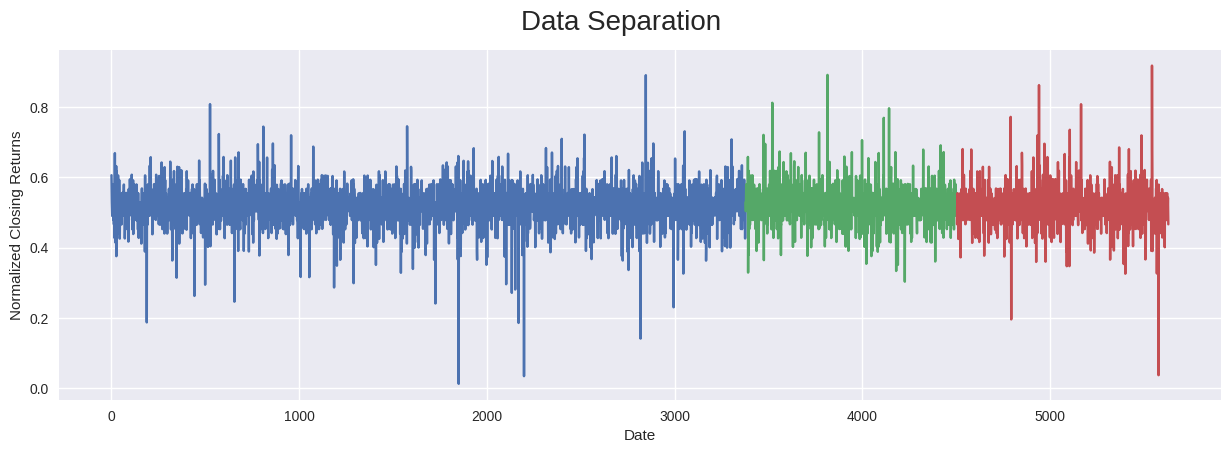

In [ ]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), train_df['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]), val_df['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), test_df['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')


## Create chunks of training, validation and test data

In [ ]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(df_X_train[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(df_y_train[i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(df_X_val[i-seq_len:i])
    y_val.append(df_y_val[i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(df_X_test[i-seq_len:i])
    y_test.append(df_y_test[i])
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(3251, 128, 17) (3251,)
(998, 128, 17) (998,)


## 1D Convolution layers for a CNN+LSTM model


In [ ]:
def Inception_A(layer_in, c7):
  branch1x1_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch1x1 = BatchNormalization()(branch1x1_1)
  branch1x1 = ReLU()(branch1x1)

  branch5x5_1 = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(layer_in)
  branch5x5 = BatchNormalization()(branch5x5_1)
  branch5x5 = ReLU()(branch5x5)
  branch5x5 = Conv1D(c7, kernel_size=5, padding='same', use_bias=False)(branch5x5)
  branch5x5 = BatchNormalization()(branch5x5)
  branch5x5 = ReLU()(branch5x5)

  branch3x3_1 = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(layer_in)
  branch3x3 = BatchNormalization()(branch3x3_1)
  branch3x3 = ReLU()(branch3x3)
  branch3x3 = Conv1D(c7, kernel_size=3, padding='same', use_bias=False)(branch3x3)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3)
  branch3x3 = Conv1D(c7, kernel_size=3, padding='same', use_bias=False)(branch3x3)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3)

  branch_pool = AveragePooling1D(pool_size=(3), strides=1, padding='same')(layer_in)
  branch_pool = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(branch_pool)
  branch_pool = BatchNormalization()(branch_pool)
  branch_pool = ReLU()(branch_pool)
  outputs = Concatenate(axis=-1)([branch1x1, branch5x5, branch3x3, branch_pool])
  return outputs


def Inception_B(layer_in, c7):
  branch3x3 = Conv1D(c7, kernel_size=3, padding="same", strides=2, use_bias=False)(layer_in)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3)

  branch3x3dbl = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)
  branch3x3dbl = Conv1D(c7, kernel_size=3, padding="same", use_bias=False)(branch3x3dbl)
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)
  branch3x3dbl = Conv1D(c7, kernel_size=3, padding="same", strides=2, use_bias=False)(branch3x3dbl)
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)

  branch_pool = MaxPooling1D(pool_size=3, strides=2, padding="same")(layer_in)

  outputs = Concatenate(axis=-1)([branch3x3, branch3x3dbl, branch_pool])
  return outputs


def Inception_C(layer_in, c7):
  branch1x1_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch1x1 = BatchNormalization()(branch1x1_1)
  branch1x1 = ReLU()(branch1x1)

  branch7x7_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch7x7 = BatchNormalization()(branch7x7_1)
  branch7x7 = ReLU()(branch7x7)
  branch7x7 = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7)
  branch7x7 = BatchNormalization()(branch7x7)
  branch7x7 = ReLU()(branch7x7)
  branch7x7 = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7)
  branch7x7 = BatchNormalization()(branch7x7)
  branch7x7 = ReLU()(branch7x7)

  branch7x7dbl_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch7x7dbl = BatchNormalization()(branch7x7dbl_1)
  branch7x7dbl = ReLU()(branch7x7dbl)
  branch7x7dbl = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7dbl)
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)
  branch7x7dbl = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7dbl)
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)
  branch7x7dbl = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7dbl)
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)
  branch7x7dbl = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7dbl)
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)

  branch_pool = AveragePooling1D(pool_size=3, strides=1, padding='same')(layer_in)
  branch_pool = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(branch_pool)
  branch_pool = BatchNormalization()(branch_pool)
  branch_pool = ReLU()(branch_pool)

  outputs = Concatenate(axis=-1)([branch1x1, branch7x7, branch7x7dbl, branch_pool])
  return outputs

# **Testing different model architectures**


## Create function for testing models

In [ ]:
def run_model(model):
  model.summary()
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

  model.fit(X_train, y_train,
                batch_size=2048,
                verbose=2,
                callbacks=[callback],
                epochs=epochs,
                shuffle=True,
                validation_data=(X_val, y_val),)

  ###############################################################################
  '''Calculate predictions and metrics'''

  #Calculate predication for training, validation and test data
  train_pred = model.predict(X_train)
  val_pred = model.predict(X_val)
  test_pred = model.predict(X_test)

  #Print evaluation metrics for all datasets
  train_eval = model.evaluate(X_train, y_train, verbose=0)
  val_eval = model.evaluate(X_val, y_val, verbose=0)
  test_eval = model.evaluate(X_test, y_test, verbose=0)
  print(' ')
  print('Evaluation metrics')
  print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}, ACC: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2], train_eval[3]))
  print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}, ACC: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2] , val_eval[3]))
  print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}, ACC: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2], test_eval[3]))

  ###############################################################################
  '''Display results'''

  fig = plt.figure(figsize=(15,15))
  st = fig.suptitle("Bi-LSTM Model", fontsize=22)
  st.set_y(1.02)

  #Plot training data results
  ax11 = fig.add_subplot(311)
  ax11.plot(train_data[:, 0], label='Asset Closing price')
  ax11.plot(train_pred, color='yellow', linewidth=3, label='Predicted asset Closing Returns')
  ax11.set_title("Training Data", fontsize=18)
  ax11.set_xlabel('Date')
  ax11.set_ylabel('IBM Closing Returns')

  #Plot validation data results
  ax21 = fig.add_subplot(312)
  ax21.plot(val_data[:, 0], label='Asset Closing price')
  ax21.plot(val_pred, color='yellow', linewidth=3, label='Predicted Asset Closing Returns')
  ax21.set_title("Validation Data", fontsize=18)
  ax21.set_xlabel('Date')
  ax21.set_ylabel('IBM Closing Returns')

  #Plot test data results
  ax31 = fig.add_subplot(313)
  ax31.plot(test_data[:, 0], label='Asset Closing price')
  ax31.plot(test_pred, color='yellow', linewidth=3, label='Predicted Asset Closing Returns')
  ax31.set_title("Test Data", fontsize=18)
  ax31.set_xlabel('Date')
  ax31.set_ylabel('Asset Closing Returns')

  plt.tight_layout()
  plt.legend(loc='best')

## Bi-LSTM model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 17)]    0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 128, 256)     149504      ['input_1[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 128, 256)    394240      ['bidirectional[0][0]']          
 )                                                                                                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 128, 128)    164352      ['bidirectional_1[0][0]']    

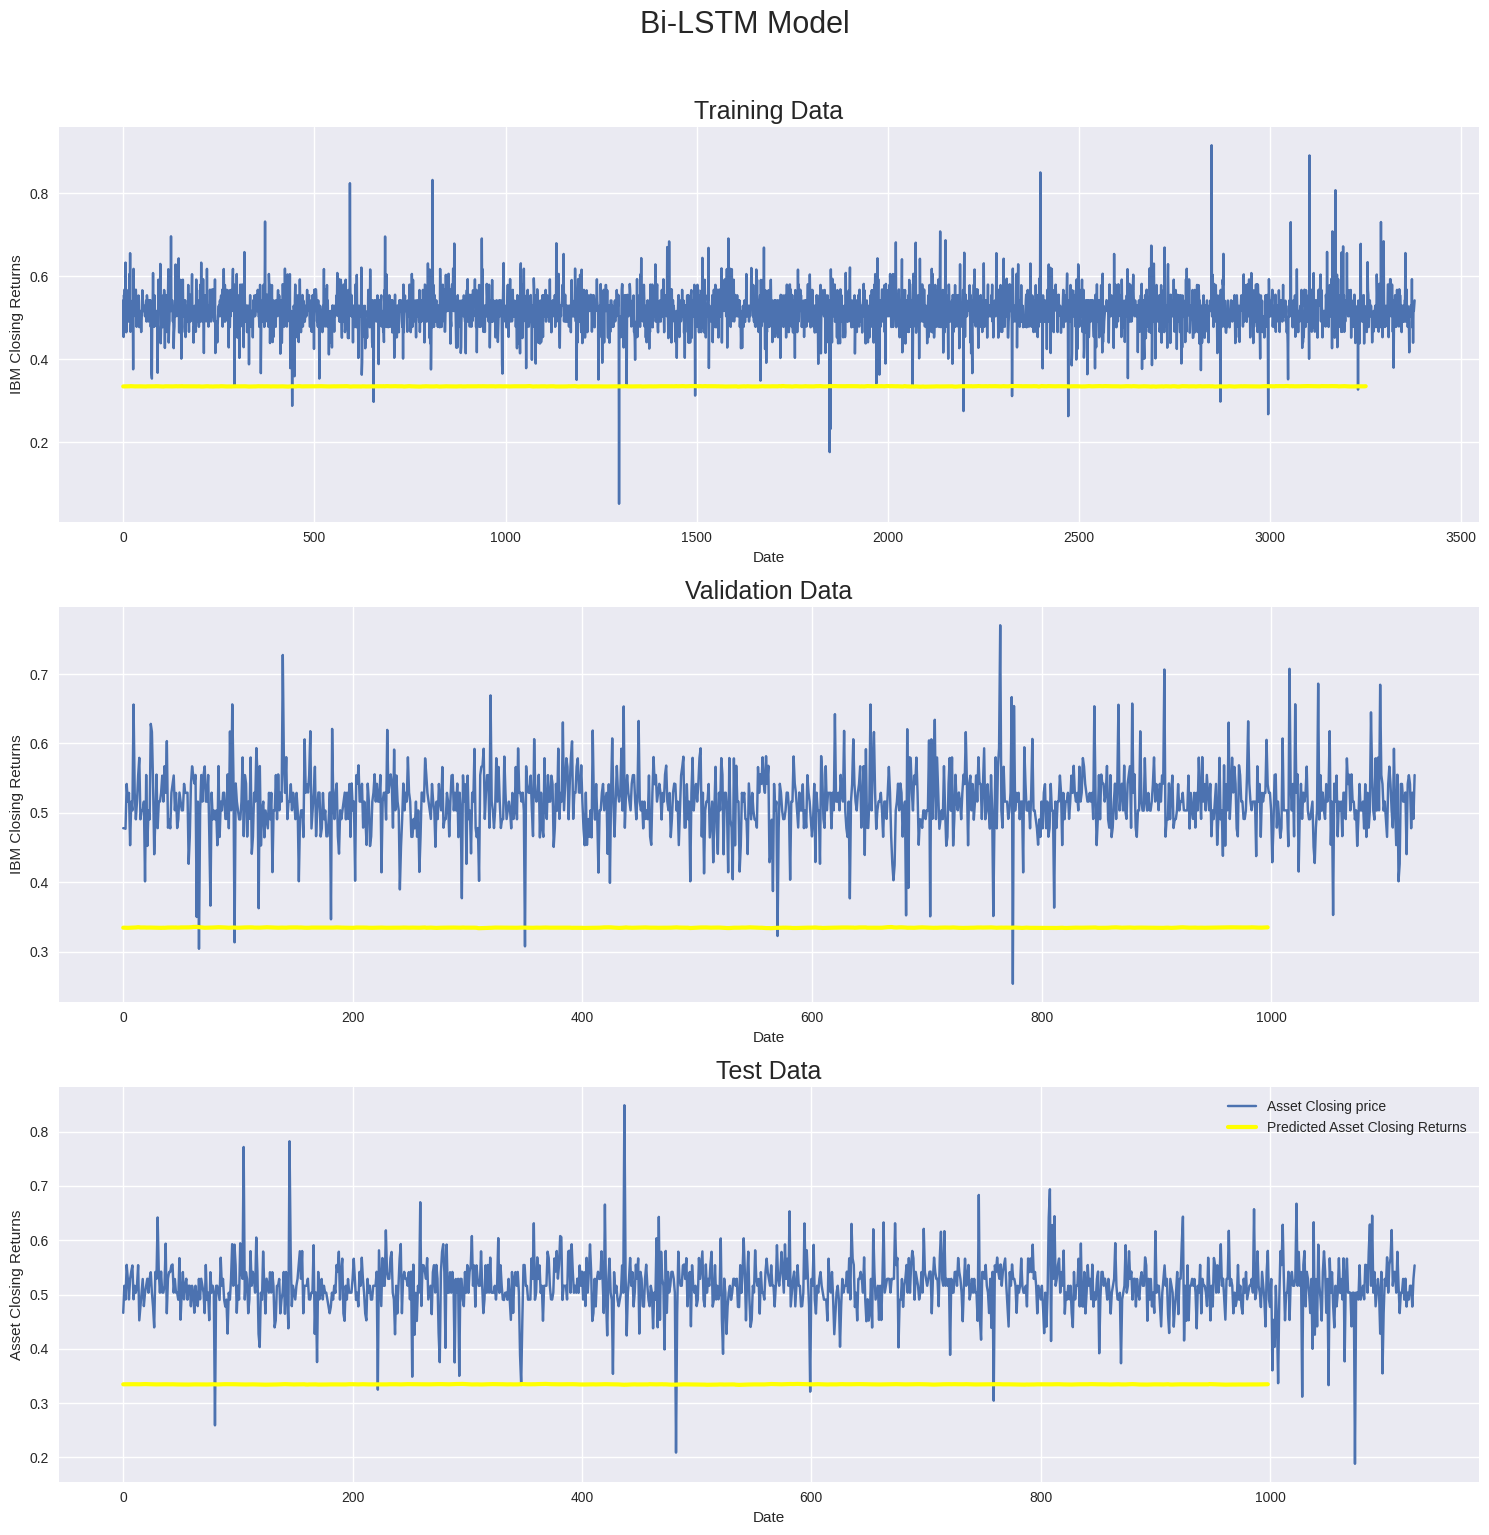

In [ ]:
def create_model_BI_LSTM():
  in_seq = Input(shape = (seq_len, len(X_cols)))

  x = Bidirectional(LSTM(128, return_sequences=True))(in_seq)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x)

  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="linear")(conc)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape', 'accuracy'])
  return model

model_BI_LSTM = create_model_BI_LSTM()
run_model(model_BI_LSTM)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128, 256)          289792    
                                                                 
 dropout (Dropout)           (None, 128, 256)          0         
                                                                 
 lstm_4 (LSTM)               (None, 128, 256)          525312    
                                                                 
 dropout_1 (Dropout)         (None, 128, 256)          0         
                                                                 
 lstm_5 (LSTM)               (None, 128, 256)          525312    
                                                                 
 dropout_2 (Dropout)         (None, 128, 256)          0         
                                                                 
 lstm_6 (LSTM)               (None, 256)               5

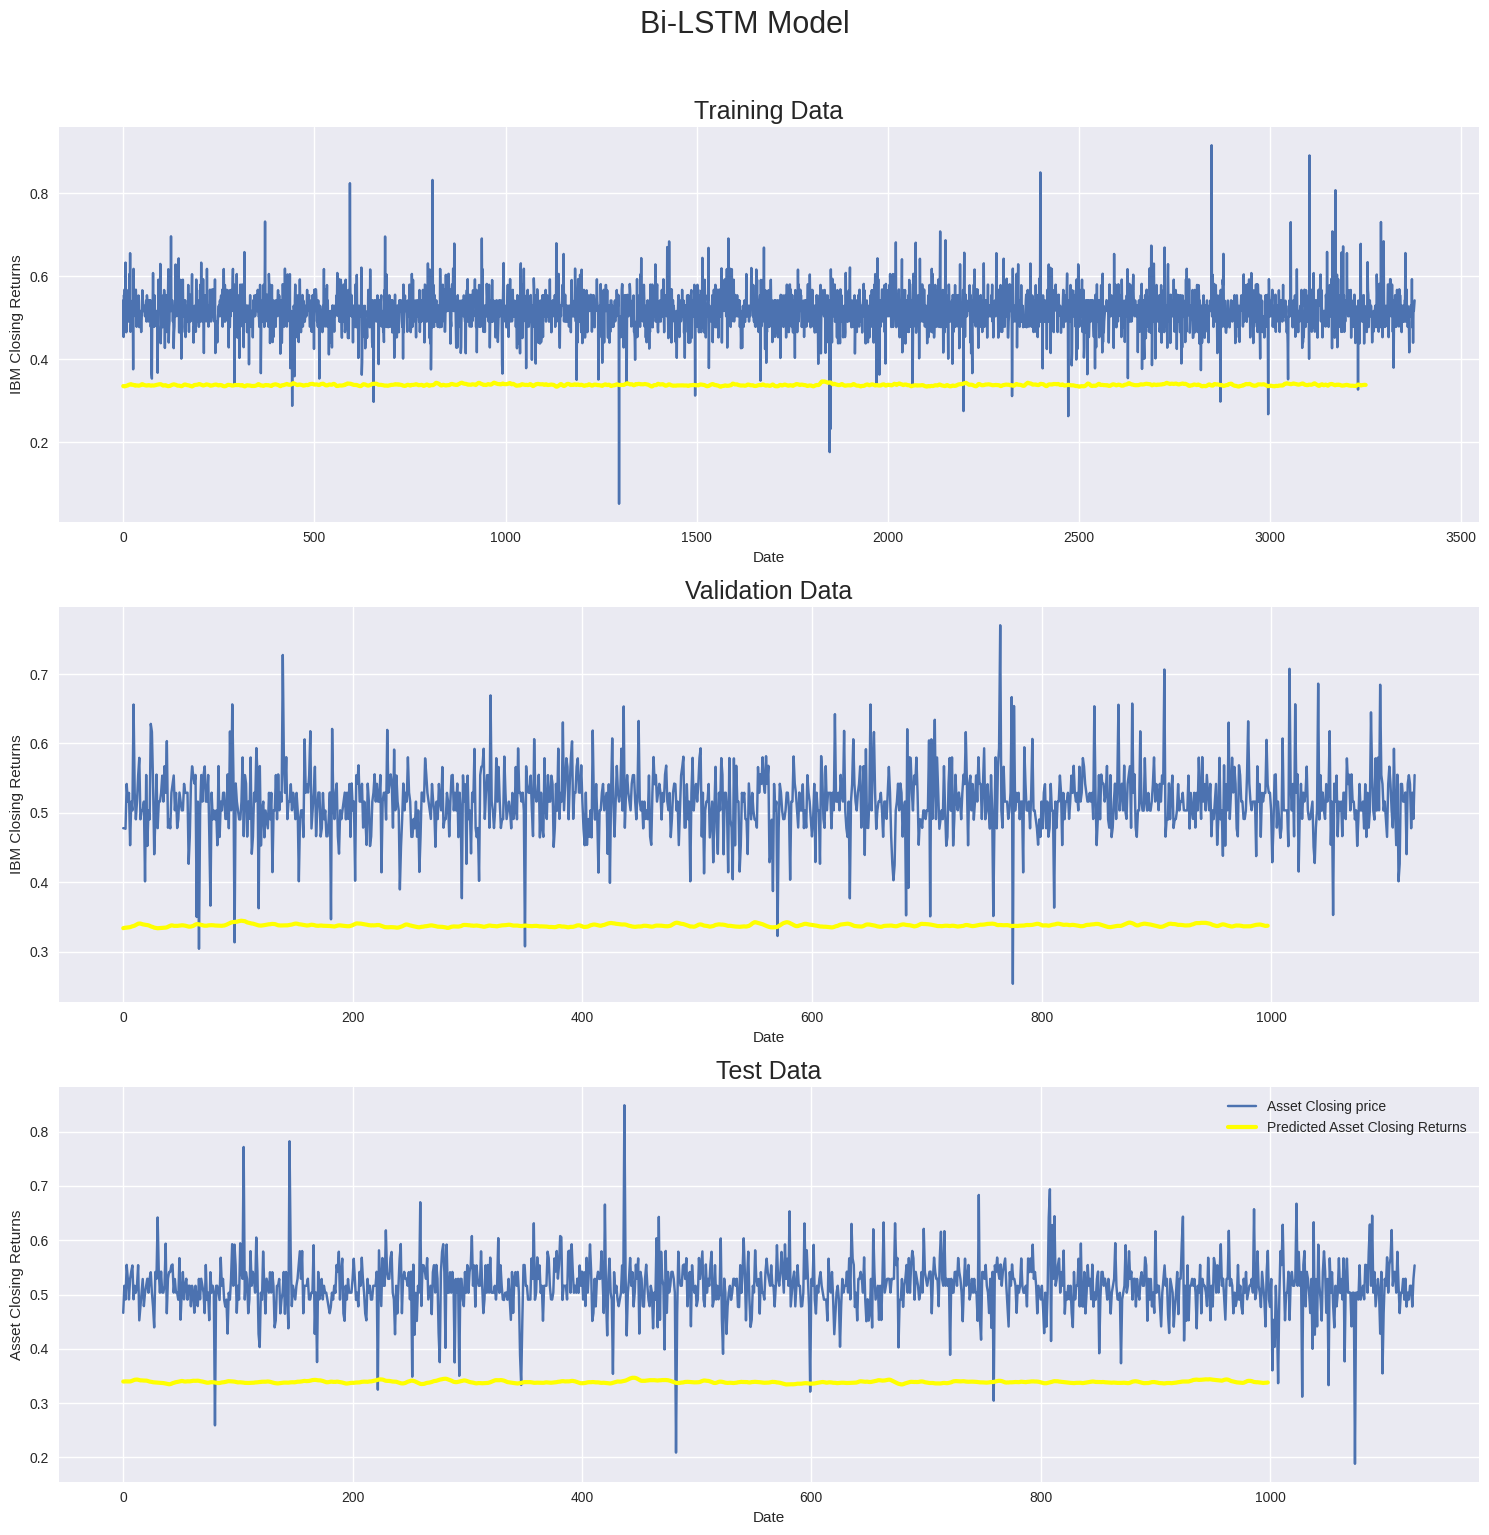

In [ ]:
def create_model_LSTM():
  model = Sequential()
  model.add(LSTM(units = 256, return_sequences = True, input_shape = (seq_len, len(X_cols))))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 256, return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 256, return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 256))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1, activation='sigmoid'))

  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape', 'accuracy'])
  return model

model_LSTM = create_model_LSTM()
run_model(model_LSTM)

### CNN + Bi-LSTM model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 26)]    0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 128, 32)      832         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 32)     128         ['conv1d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 re_lu_3 (ReLU)                 (None, 128, 32)      0           ['batch_normalization_3[0][

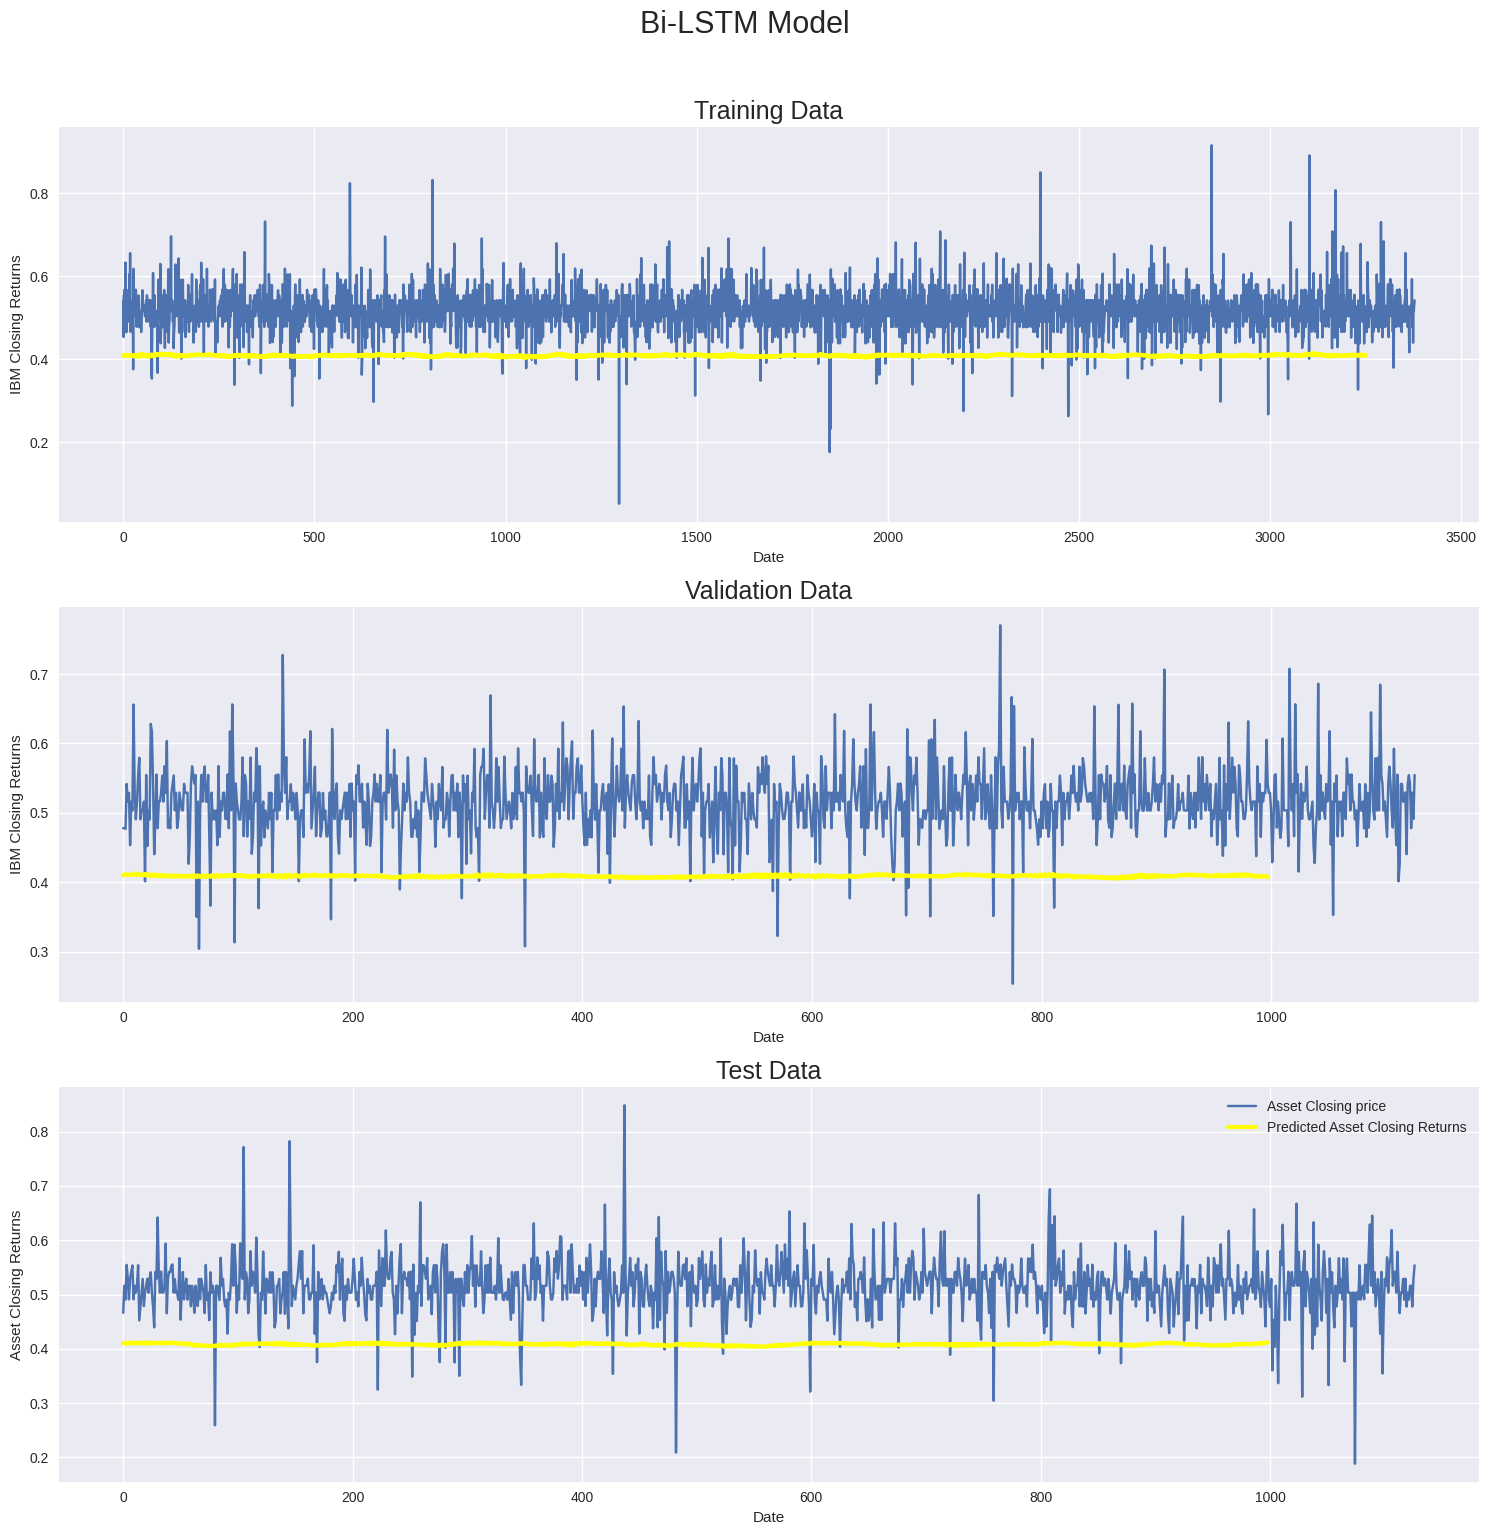

In [ ]:
def create_model_CNN_Bi_LSTM():
  in_seq = Input(shape=(seq_len, len(X_cols)))

  x = Inception_A(in_seq, 32)
  x = Inception_A(x, 32)
  x = Inception_B(x, 32)
  x = Inception_B(x, 32)
  x = Inception_C(x, 32)
  x = Inception_C(x, 32)

  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x)

  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape', 'accuracy'])
  return model

model_CNN_Bi_LSTM = create_model_CNN_Bi_LSTM()
run_model(model_CNN_Bi_LSTM)

## **Conculsion 1**
When interpreting at the evaluation metrics it seems that the networks are predicting the next day closing price returns very well. The Bi-LSTM and CNN+Bi-LSTM networks have a **mean average percentage error** **(MAPE)** of  `3.58` and `3.84` for the validation set and `4.26` and `4.53` for the test set.
Making it also obvious that the Bi-LSTM network is better than the CNN+Bi-LSTM network, which honestly surprised me.

However, when taking a glance at the graphs of the validation and test set it becomes clear that the networks have merely found the center point of the return distributions. Over the entire course of the time series the networks do not divert greatly from the center.

It seems that the right and left tail of the stock return distribution are not derivable from price data alone.

I do have the following **hypotheses** that provide more room for investigation and might lead to better results.

#### **Hypotheses**

1. The stock returns seem very rugged, which could make the networks interpret the distribution tails as semi-random. --> smooth returns with **moving average**

2. We do need more price data to derive temporal dependencies of the time series and get a better understanding of the distribution tails. --> Obtain **more price data** of different stocks, etfs, etc.

3. In order to predict the stock return distribution tails more accurately include additional features e.g. **financial news, company's balance sheet and P&L**

The first hypothesis we'll also implement in this notebook.

The second and third hypothesis will be addressed at a later stage.




# **Moving Average Analysis**

## Loading financial data again to apply a moving average effect

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,returns,target
Datetime,,,,,,,
2023-05-16 02:30:00,1.088116,1.088376,1.087938,1.088175,1.088495,0.000054,0
2023-05-16 02:45:00,1.088139,1.088388,1.087950,1.088199,1.088139,0.000022,0
2023-05-16 03:00:00,1.088139,1.088388,1.087903,1.088210,1.087784,0.000011,1
2023-05-16 03:15:00,1.088128,1.088376,1.087891,1.088234,1.087903,0.000022,1
2023-05-16 03:30:00,1.088139,1.088412,1.087903,1.088281,1.088495,0.000044,1


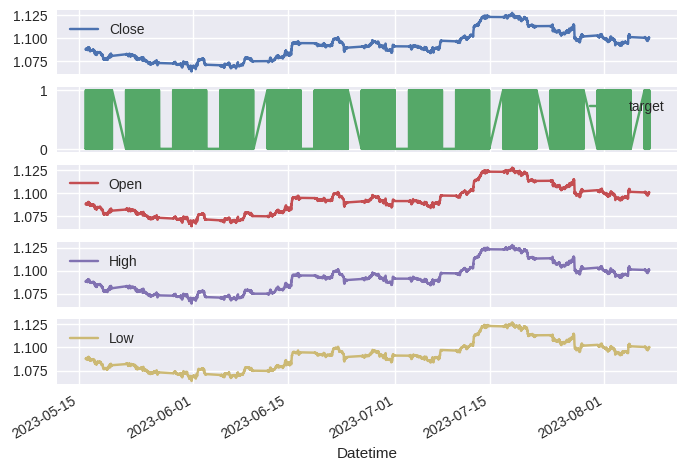

In [ ]:
df = get_yfinance_hist(symbol = symbol, period = period, interval= interval )

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'returns']] = df[['Open', 'High', 'Low', 'Close', 'returns']].rolling(10).mean()

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True)

df.head()

## Moving Average - Plot daily IBM closing prices

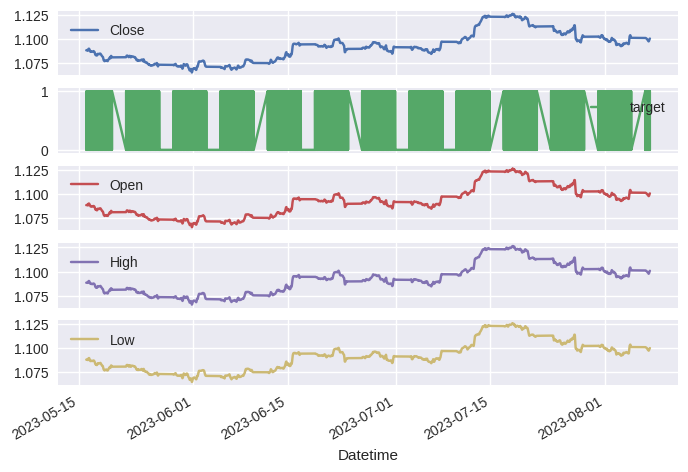

In [ ]:
plot_cols = ['Close', 'target', 'Open', 'High', 'Low']
plot_features = df[plot_cols]
plot_features.index = df.index
_ = plot_features.plot(subplots=True)

## Moving Average - Calculate normalized percentage change for all columns

In [ ]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)



## Split the df dataframe into test, train and validation dataset

In [ ]:
train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42),
                       [int(.6*len(df)), int(.8*len(df))])

X_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'returns']
y_cols = 'target'

df_X_train = train_df[X_cols]
df_y_train = train_df[y_cols]

df_X_val = val_df[X_cols]
df_y_val = val_df[y_cols]

df_X_test = test_df[X_cols]
df_y_test = test_df[y_cols]

## Moving Average - Create chunks of training, validation and test data

In [ ]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(3251, 128, 27) (3251,)
(998, 128, 27) (998,)


# **Moving Average - Testing different model architectures**

### Moving Average - Bi-LSTM model

In [ ]:
def create_model():
  in_seq = Input(shape = (seq_len, 7))

  x = Bidirectional(LSTM(128, return_sequences=True))(in_seq)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x)

  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape', 'accuracy'])
  return model

model = create_model()
run_model(model)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 7)]     0           []                               
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 128, 256)    139264      ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 bidirectional_7 (Bidirectional  (None, 128, 256)    394240      ['bidirectional_6[0][0]']        
 )                                                                                                
                                                                                            

ValueError: ignored

### Moving Average - CNN + Bi-LSTM model

In [ ]:
def create_model():
  in_seq = Input(shape=(seq_len, 7))

  x = Inception_A(in_seq, 32)
  x = Inception_A(x, 32)
  x = Inception_B(x, 32)
  x = Inception_B(x, 32)
  x = Inception_C(x, 32)
  x = Inception_C(x, 32)

  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x)

  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape', 'accuracy'])
  return model

model = create_model()
run_model(model)

## **Conculsion 2**

As expected applying a moving average to the price data smoothed the return distribution and thus lead to an improved model performance.

However, when applying a moving average effect to a time series your dataset represent the real market less accurately. Subsequently, your dataset is biased towards less outliers.

When investing in the stock market it is curcial that outliers are not excluded or smoothed out since outliers majorly contribute to your trading performance.

Thus, any data transformations that can't be easily reverted once the predictions have been made, should be avoided.

Nevertheless, seeing that a slight smoothing of the time series improved the error rates substantially for the Bi-LSTM model is a good thing to consider for future work.

In conculsion, I'll be looking for other prediction indicators which will be adding to the model's performance.

*Next up are financial news...*


##### **Moving Average Bi-LSTM**
> Validation Data --> Loss: `0.0005`, MAE: `0.0170`, MAPE: `3.0885`

> Test Data --> Loss: `0.0009`, MAE: `0.0201`, MAPE: `4.0887`

##### **Bi-LSTM**
>Validation Data --> Loss: `0.0009`, MAE: `0.0211`, MAPE: `3.5828`

>Test Data --> Loss: `0.0014`, MAE: `0.0245`, MAPE: `4.2656`

---
---

##### **Moving Average CNN+Bi-LSTM**
>Validation Data --> Loss: `0.0008`, MAE: `0.0213`, MAPE: `3.8731`

>Test Data --> Loss: `0.0018`, MAE: `0.0292`, MAPE: `6.2077`

##### **CNN+Bi-LSTM**
>Validation Data --> Loss: `0.0010`, MAE: `0.0229`, MAPE: `3.8454`

>Test Data --> Loss: `0.0015`, MAE: `0.0264`, MAPE: `4.5289`